In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

import eli5
from eli5.sklearn import PermutationImportance

In [2]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
datafix = '../data/datafix.csv'

concat_select = pd.read_csv(datafix)

## 5. Model Training

- 이제 위에서 만든 파생변수들과 정제한 데이터를 기반으로 본격적으로 부동산 실거래가를 예측하는 모델링을 진행하겠습니다.
- 모델링에는 `sklearn`의 `RandomForest`를 이용하도록 하겠습니다.

- 참고 ✅
  - `RandomForest`는 배깅(Bagging)의 일종으로, 학습시키는 데이터 뿐 아니라 특성변수(X)들도 무작위로 선택해 트리를 생성하는 방법입니다.
  - 모델 학습 과정에서 서로 다른 N개의 Tree 생성하고, N개의 Tree에서 발생한 Output을 Voting(범주형, 분류문제)하거나, Average(연속형, 회귀문제)해 최종 Output 생성합니다.
  - 이는 High variance, Low bias 상황에서 분산(Variance) 감소에 도움을 줍니다.

In [3]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1117519, 23) (9272, 23)


In [4]:
dt_test.head(1)

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,구,동,...,평형대,price_increase_rate,동등급,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부
1117519,개포6차우성,79.97,26,5,1987,127.05721,37.476763,0.0,강남구,개포동,...,중형,5.42061,1,2,2,8학군,619,11345,3.5,0


In [5]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

### 5.1. 범주형 변수 Encoding
- 범주형 변수는 그대로 모델에 투입하면, 모델이 제대로 작동할 수 없습니다.
- 따라서 **레이블 인코딩 과정**을 통해 범주형 변수들을 numeric하게 바꾸는 인코딩 과정을 진행해주도록 하겠습니다.

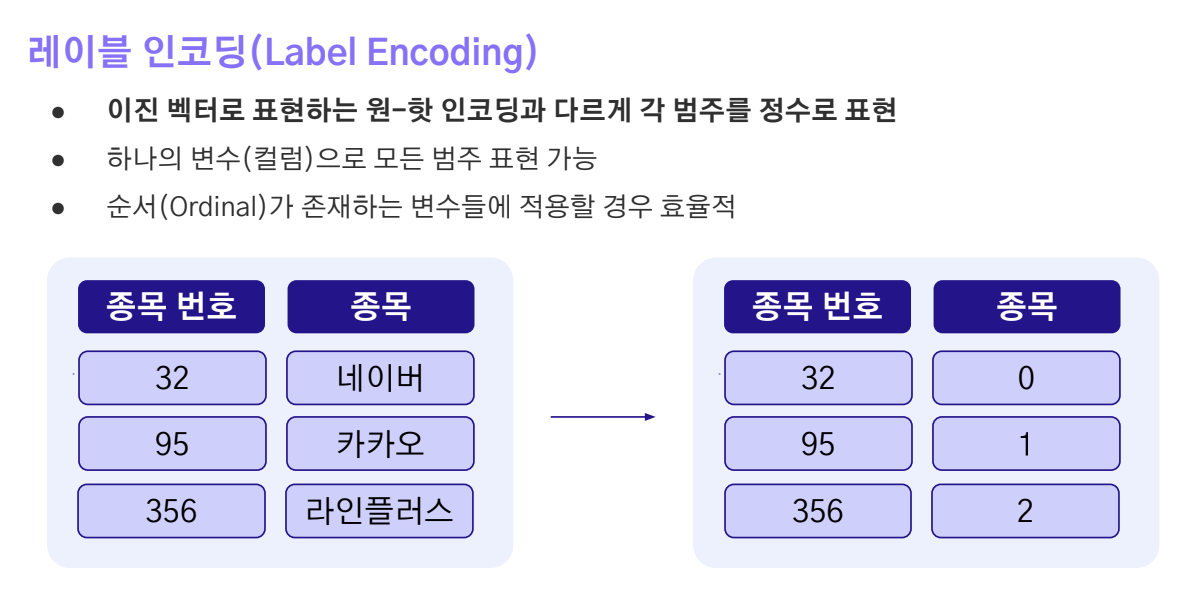

In [6]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적', '계약일', '층', '건축년도', '좌표X', '좌표Y', 'target', '계약년', '계약월', '강남여부', 'price_increase_rate', '동등급', '브랜드등급', '한강근접여부', 'closest_subway_distance', 'closest_bus_distance', '기준금리', '신축여부']
범주형 변수: ['아파트명', '구', '동', '평형대', '학군']


In [7]:
# 범주형 변수에 대한 보간
concat_select[categorical_columns_v2] = concat_select[categorical_columns_v2].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat_select[continuous_columns_v2] = concat_select[continuous_columns_v2].interpolate(method='linear', axis=0)

In [8]:
# EDA에 앞서 결측치를 확인해보겠습니다.
concat_select.isnull().sum()

아파트명                       0
전용면적                       0
계약일                        0
층                          0
건축년도                       0
좌표X                        0
좌표Y                        0
target                     0
is_test                    0
구                          0
동                          0
계약년                        0
계약월                        0
강남여부                       0
평형대                        0
price_increase_rate        0
동등급                        0
브랜드등급                      0
한강근접여부                     0
학군                         0
closest_subway_distance    0
closest_bus_distance       0
기준금리                       0
신축여부                       0
dtype: int64

In [9]:
# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# 범주형 변수에 대해 레이블 인코딩을 적용
for col in tqdm(categorical_columns_v2):
    lbl = LabelEncoder()

    # 학습 데이터와 테스트 데이터를 모두 문자열로 변환하여 처리
    dt_train[col] = dt_train[col].astype(str)
    dt_test[col] = dt_test[col].astype(str)
    
    # 학습 데이터에 대한 레이블 인코딩을 학습 및 변환
    lbl.fit(dt_train[col])
    dt_train[col] = lbl.transform(dt_train[col])
    label_encoders[col] = lbl  # 나중에 후처리를 위해 레이블 인코더 저장
    
    # Test 데이터에서 학습에 없었던 레이블을 추가하는 방식
    unseen_labels = np.setdiff1d(np.unique(dt_test[col]), lbl.classes_)
    
    # 새로운 레이블이 있으면 학습된 클래스에 추가
    if unseen_labels.size > 0:
        new_classes = np.concatenate([lbl.classes_, unseen_labels])
        lbl.classes_ = new_classes
    
    # Test 데이터에 변환을 적용
    dt_test[col] = lbl.transform(dt_test[col])


100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


### 5.2. Model Training
- 위 데이터를 이용해 모델을 train 해보겠습니다. 모델은 XGBoost 이용하겠습니다.
- 마크다운에 RandomForest관련 사항은 삭선표시해두었습니다.

In [10]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [11]:
original_columns = dt_train.columns  # 원래 컬럼명 저장
column_mapping = {col: f"col_{i}" for i, col in enumerate(original_columns)}  # 간략한 영어 컬럼명 생성
reverse_mapping = {v: k for k, v in column_mapping.items()}  # 복원을 위한 매핑

In [12]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [13]:
import lightgbm as lgb

# 컬럼명 변경
X_train.rename(columns=column_mapping, inplace=True)
X_val.rename(columns=column_mapping, inplace=True)

# LightGBM Dataset 준비
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [14]:
# LightGBM 하이퍼파라미터 설정
params = {
    "objective": "regression",         # 회귀 문제로 설정
    "metric": "rmse",                  # RMSE를 평가 지표로 설정
    "boosting_type": "gbdt",           # 부스팅 방식
    "num_leaves": 31,                  # 리프 노드 개수
    "learning_rate": 0.05,             # 학습률
    "feature_fraction": 0.9            # 사용할 피처 비율
}

# 콜백 함수 설정 (조기 종료 및 로그 출력)
callbacks = [
    lgb.early_stopping(stopping_rounds=10),           # 조기 종료
    lgb.log_evaluation(period=10)                    # 10 라운드마다 로그 출력
]

# 모델 학습
model = lgb.train(
    params,
    train_set=train_data,
    valid_sets=[train_data, val_data],  # 학습 및 검증 데이터셋
    num_boost_round=100,               # 부스팅 반복 횟수
    callbacks=callbacks                # 콜백 함수
)

# 검증 데이터 예측
y_pred = model.predict(X_val, num_iteration=model.best_iteration)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.479627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1984
[LightGBM] [Info] Number of data points in the train set: 894015, number of used features: 22
[LightGBM] [Info] Start training from score 57852.404868
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 33290.9	valid_1's rmse: 33053.8
[20]	training's rmse: 26182.7	valid_1's rmse: 26012.9
[30]	training's rmse: 22019.5	valid_1's rmse: 21909.5
[40]	training's rmse: 19353	valid_1's rmse: 19289.2
[50]	training's rmse: 17539.4	valid_1's rmse: 17525.1
[60]	training's rmse: 16310	valid_1's rmse: 16331.5
[70]	training's rmse: 15401.3	valid_1's rmse: 15453.3
[80]	training's rmse: 14722.2	valid_1's rmse: 14805.1
[90]	training's rmse: 14215.2	valid_1's rmse: 14326
[100]	training's rmse: 13748	valid_1's rmse: 138

# 모델 비교
이미 val pred RMSE가 위에 나와 있지만 그래도 보기 편하라고 한번 더 보여드림.

In [15]:
pred = model.predict(X_val)
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 13876.972452091424


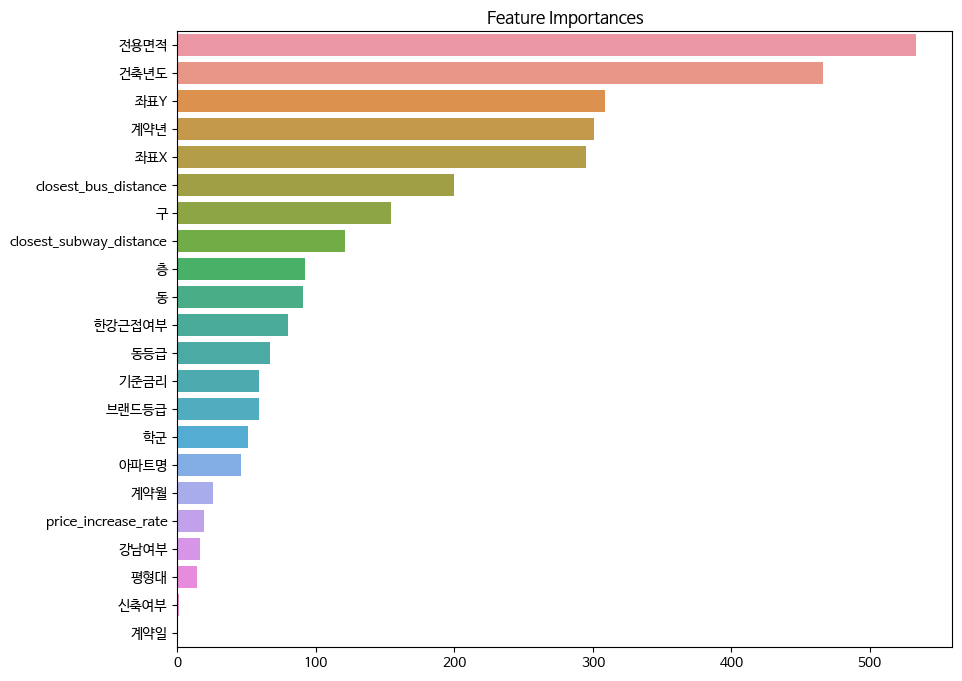

In [16]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importance(), index=list(X_train.columns))
importances = importances.sort_values(ascending=False)


# 컬럼명을 원래 이름으로 복원
importances.index = [reverse_mapping[col] for col in importances.index]

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [17]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### 5.3. Feature selection

- 어떤 변수가 유용한 변수인지 확인해보기 위해 permutation selection을 이용해보겠습니다.

In [18]:
from lightgbm import LGBMRegressor

# LGBMRegressor 모델 학습
lgbm_model = LGBMRegressor(objective='regression', random_state=42)
lgbm_model.fit(X_train, y_train)

# Permutation Importance 계산
perm = PermutationImportance(lgbm_model,        # LGBMRegressor 모델을 사용
                             scoring='neg_mean_squared_error',  # 음의 평균 제곱 오차를 사용
                             random_state=42,
                             n_iter=3).fit(X_val, y_val)


# 컬럼명을 원래 이름으로 복원
original_feature_names = [reverse_mapping[col] for col in X_val.columns]

# 결과 시각화
eli5.show_weights(perm, feature_names=original_feature_names, top=len(X_val.columns))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1985
[LightGBM] [Info] Number of data points in the train set: 894015, number of used features: 22
[LightGBM] [Info] Start training from score 57852.404868


Weight,Feature
876502419.7208 ± 8670811.8069,전용면적
839983204.8250 ± 13029235.7417,계약년
292547185.2752 ± 1432281.4547,동등급
208874909.7986 ± 3674472.9884,건축년도
172042284.1892 ± 2030196.9978,closest_bus_distance
120866441.0259 ± 1307917.0763,좌표Y
108262885.5581 ± 1575275.0947,좌표X
73541754.9675 ± 650301.9316,구
28795526.2742 ± 1024093.1137,한강근접여부
25018999.6540 ± 200249.3361,브랜드등급


### 5.4. Valid prediction 분석

- 예측값을 분석해보기 위해 valid prediction을 확인해보겠습니다.

In [19]:
X_val.columns = [reverse_mapping.get(col, col) for col in X_val.columns]

# Validation dataset에 target과 pred 값을 채워주도록 하겠습니다.
X_val['target'] = y_val
X_val['pred'] = pred

In [20]:
# Squared_error를 계산하는 함수를 정의하겠습니다.
def calculate_se(target, pred):
    squared_errors = (target - pred) ** 2
    return squared_errors

# RMSE 계산
squared_errors = calculate_se(X_val['target'], X_val['pred'])
X_val['error'] = squared_errors


In [21]:
# Error가 큰 순서대로 sorting 해 보겠습니다.
X_val_sort = X_val.sort_values(by='error', ascending=False)       # 내림차순 sorting

In [22]:
X_val_sort.head()

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
288307,1848,227.370,25,2,2019,127.009942,37.531536,20,312,2021,...,2,1,6,635,780,0.5,1,400000.0,805136.367139,1.641355e+11
221668,1848,227.370,21,2,2019,127.009942,37.531536,20,312,2023,...,2,1,6,635,780,3.5,1,465000.0,855018.411214,1.521144e+11
288306,1848,238.380,24,3,2019,127.009942,37.531536,20,312,2021,...,2,1,6,635,780,0.5,1,450000.0,805239.958770,1.261954e+11
635043,5930,244.783,18,3,2011,127.009496,37.536978,20,312,2016,...,2,1,6,635,1081,1.5,0,790000.0,437743.944303,1.240843e+11
719124,5673,273.860,7,5,2002,127.002921,37.486202,14,151,2015,...,2,2,9,733,10863,2.0,0,490000.0,152285.058779,1.140514e+11


- 예측을 잘 하지 못한 top 100개의 데이터와 예측을 잘한 top 100개의 데이터를 비교해보겠습니다.

In [23]:
X_val_sort_top100 = X_val.sort_values(by='error', ascending=False).head(100)        # 예측을 잘 하지못한 top 100개의 data
X_val_sort_tail100 = X_val.sort_values(by='error', ascending=False).tail(100)       # 예측을 잘한 top 100개의 data

In [24]:
# 해석을 위해 레이블인코딩 된 변수를 복원해줍니다.
error_top100 = X_val_sort_top100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    error_top100[column] = label_encoders[column].inverse_transform(X_val_sort_top100[column])

best_top100 = X_val_sort_tail100.copy()
for column in categorical_columns_v2 :     # 앞서 레이블 인코딩에서 정의했던 categorical_columns_v2 범주형 변수 리스트를 사용합니다.
    best_top100[column] = label_encoders[column].inverse_transform(X_val_sort_tail100[column])

In [25]:
display(error_top100.head(5))
display(best_top100.head(1))

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
288307,르가든더메인한남,227.370,25,2,2019,127.009942,37.531536,용산구,한남동,2021,...,2,1,5학군,635,780,0.5,1,400000.0,805136.367139,1.641355e+11
221668,르가든더메인한남,227.370,21,2,2019,127.009942,37.531536,용산구,한남동,2023,...,2,1,5학군,635,780,3.5,1,465000.0,855018.411214,1.521144e+11
288306,르가든더메인한남,238.380,24,3,2019,127.009942,37.531536,용산구,한남동,2021,...,2,1,5학군,635,780,0.5,1,450000.0,805239.958770,1.261954e+11
635043,한남더힐,244.783,18,3,2011,127.009496,37.536978,용산구,한남동,2016,...,2,1,5학군,635,1081,1.5,0,790000.0,437743.944303,1.240843e+11
719124,트라움하우스3,273.860,7,5,2002,127.002921,37.486202,서초구,서초동,2015,...,2,2,8학군,733,10863,2.0,0,490000.0,152285.058779,1.140514e+11


,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,구,동,계약년,...,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부,target,pred,error
725235,길음뉴타운2단지푸르지오,84.97,21,11,2005,127.016166,37.611826,성북구,길음동,2015,...,1,2,11학군,28,2993,2.0,0,41900.0,41904.287522,18.382845


- 이제 분포를 비교해보도록 하겠습니다.

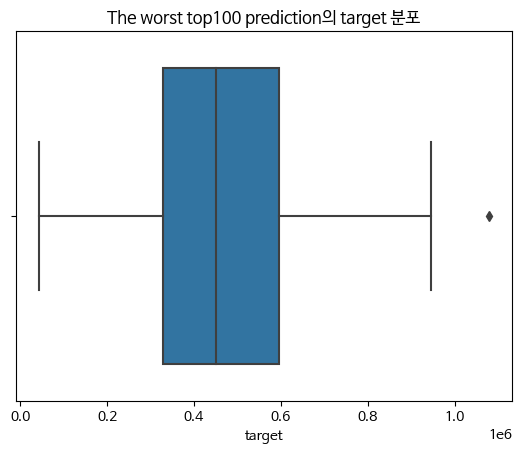

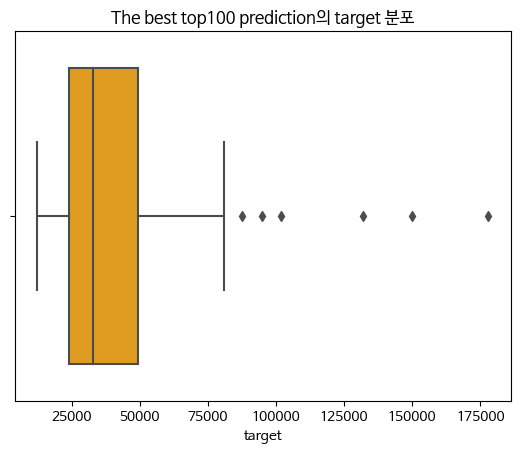

In [26]:
sns.boxplot(data = error_top100, x='target')
plt.title('The worst top100 prediction의 target 분포')
plt.show()

sns.boxplot(data = best_top100, x='target', color='orange')
plt.title('The best top100 prediction의 target 분포')
plt.show()

- Taget 분포를 보니 좋은 예측을 보인 top 100개의 data보다 상대적으로 나쁜 예측을 보인 top 100 dataset들이 높은 가격을 보였음을 확인할 수 있습니다. 이에 대한 모델링 및 처리가 필요해보입니다.

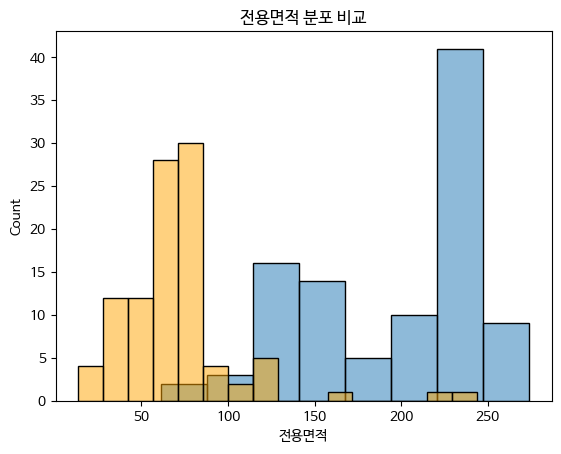

In [27]:
sns.histplot(data = error_top100, x='전용면적', alpha=0.5)
sns.histplot(data = best_top100, x='전용면적', color='orange', alpha=0.5)
plt.title('전용면적 분포 비교')
plt.show()

- 전용면적 또한 나쁜 예측을 보인 집들이 더 넓음을 확인할 수 있습니다.

## 6. Inference

In [28]:
dt_test.head(2)      # test dataset에 대한 inference를 진행해보겠습니다.

,아파트명,전용면적,계약일,층,건축년도,좌표X,좌표Y,target,구,동,...,평형대,price_increase_rate,동등급,브랜드등급,한강근접여부,학군,closest_subway_distance,closest_bus_distance,기준금리,신축여부
1117519,328,79.9700,26,5,1987,127.057210,37.476763,0,0,8,...,2,5.42061,1,2,2,9,619,11345,3.5,0
1117520,329,108.2017,15,10,2021,127.056394,37.484892,0,0,8,...,0,5.42061,1,1,2,9,619,11236,3.5,1


In [29]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [30]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: user 716 ms, sys: 2.67 ms, total: 719 ms
Wall time: 18.2 ms


In [31]:
real_test_pred          # 예측값들이 출력됨을 확인할 수 있습니다.

array([196038.65055685, 273775.09383424, 331744.53291909, ...,
        94819.32832032,  87136.22505747,  80965.78198239])

## 7. Output File Save

In [32]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output_LGBM.csv', index=False)